In [1]:
import pandas as pd
import math

from fastai.structured import *

from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict, defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from scipy import sparse
from sklearn.preprocessing import LabelBinarizer
import gc
import lightgbm as lgb
from sklearn.decomposition import TruncatedSVD
from skopt import gp_minimize
import threading
from keras import Model

import keras.applications.xception as xception
import keras.applications.vgg16 as vgg
import keras.applications.resnet50 as resnet
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm

from pathlib import PurePath

import bcolz

/home/axel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

In [7]:
def calculate_mean_deal_prob(dic):
    probabilities = list(dic.values())
    probs = []
    for p in probabilities:
        probs.append(p['deal_probability'])
        
    return sum(probs) / float(len(probs))

In [8]:
def calculate_feature_importance(m, cols):
    headers = ["name", "score"]
    values = sorted(zip(cols, m.feature_importances_), key=lambda x: x[1] * -1)
    return values

In [9]:
def get_predictions(df, dic, mean):
    y_pred = []
    
    for row in df.itertuples():
        category_name = row.category_name

        if category_name in dic:
            y_pred.append(dic[category_name]['deal_probability'])
        else:
            y_pred.append(mean)
    
    return y_pred

In [10]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [11]:
def group_target_by_fields(df, target, fields = None):
    if fields is None:
        fields = df.columns
    
    target_mean = df[target].mean()
    target_std = df[target].std()
    
    for f in fields:
        gp = df.groupby(f)[target]
        mean = gp.mean()
        std  = gp.std()
        
        if pd.DataFrame(mean).isnull().values.any():
            mean = mean.fillna(target_mean)
            
        if pd.DataFrame(std).isnull().values.any():
            std = std.fillna(target_std)
            
        df[f + '_' + target + '_avg'] = df[f].map(mean)
        df[f + '_' + target + '_std'] = df[f].map(std)

In [12]:
def add_to_df(df, new_field, dic):
    mean = calculate_mean_deal_prob(dic)
    new_col = np.zeros((len(df),1))
    field = new_field
    
    if field.endswith('_mean'):
        field = field[:-5]
    
    i = 0
    
    for _, row in df.iterrows():

        if row[field] in dic:
            new_col[i] = dic[row[field]]['deal_probability']
        else:
            new_col[i] = mean
        
        i = i + 1    
        
    df[new_field] = new_col

In [13]:
def string_columns_to_categorical(df):
    train_cats(df)

In [14]:
def remove_na_columns(df):
    for c in df.columns:
        if c.endswith('_na'):
            df.drop(labels=[c], axis=1, inplace=True)

In [15]:
def remove_columns_with_nans(df):
    for c in df.columns:
        if df[c].isnull().values.any():
            df.drop(labels=[c], axis=1, inplace=True)

In [16]:
def objective(space):
    n_estimators = int(space['n_estimators'])
    max_depth = int(space['max_depth'])
    min_child_weight = space['min_child_weight']
    subsample = space['subsample']
    reg_alpha = space['reg_alpha']
    reg_lambda = space['reg_lambda']
    colsample_bylevel = space['colsample_bylevel']
    colsample_bytree = space['colsample_bytree']
    learning_rate = space['learning_rate']
    gamma = space['gamma']
    #scale_pos_weight = space['scale_pos_weight']
    
    print("params: ")
    print("n_estimators: " + str(n_estimators))
    print("max_depth: " + str(max_depth))
    print("min_child_weight: " + str(min_child_weight))
    print("subsample: " + str(subsample))
    print("reg_alpha: " + str(reg_alpha))
    print("reg_lambda: " + str(reg_lambda))
    print("colsample_bylevel: " + str(colsample_bylevel))
    print("colsample_bytree: " + str(colsample_bytree))
    print("learning rate: " + str(learning_rate))
    print("gamma: " + str(gamma))
    #print("scale_pos_weight: " + str(scale_pos_weight))
        
    clf = xgb.XGBRegressor(n_jobs=4,
                        #scale_pos_weight = scale_pos_weight,
                        n_estimators = n_estimators, 
                        learning_rate = learning_rate,
                        max_depth = max_depth,
                        min_child_weight = min_child_weight,
                        subsample = subsample,
                        reg_alpha = reg_alpha,
                        reg_lambda = reg_lambda,
                        colsample_bylevel = colsample_bylevel,
                        colsample_bytree = colsample_bytree,
                        gamma=gamma)
    
    eval_set  = [(X_train, y_train), (X_valid, y_valid)]

    clf.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=10)
  
    y_pred = clf.predict(X_valid)
        
    print("rmse:" + str(rmse(y_valid, y_pred)))

    return{'loss': rmse(y_valid, y_pred), 'status': STATUS_OK }

In [17]:
def objective_lgb(space):
   
    num_leaves = int(space['num_leaves'])
    max_depth = int(space['max_depth'])
    subsample = space['subsample']
    subsample_freq = int(space['subsample_freq'])
    lambda_l1 = space['lambda_l1']
    lambda_l2 = space['lambda_l2']
    learning_rate = space['learning_rate']
    feature_fraction = space['feature_fraction']
    min_data_per_leaf = int(space['min_data_per_leaf'])
    min_child_weight = space['min_child_weight']
    
    print("params: ")
    print("num_leaves: " + str(num_leaves))
    print("max_depth: " + str(max_depth))
    print("min_child_weight: " + str(min_child_weight))
    print("subsample: " + str(subsample))
    print("subsample_freq: " + str(subsample_freq))
    print("lambda_l1: " + str(lambda_l1))
    print("lambda_l2: " + str(lambda_l2))
    print("feature_fraction: " + str(feature_fraction))
    print("learning rate: " + str(learning_rate))
    print("min_data_per_leaf: " + str(min_data_per_leaf))        
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "n_estimators": 5000,
        "max_depth": max_depth,
        "num_leaves" : num_leaves, 
        "learning_rate" : learning_rate,
        "subsample" : subsample,
        "subsample_freq" : subsample_freq,
        "lambda_l1": lambda_l1,
        "lambda_l2": lambda_l2,
        "feature_fraction" : feature_fraction,
        "min_data_per_leaf": min_data_per_leaf,
        "min_child_weight": min_child_weight,
        "bagging_seed" : 16,
        "device" : "gpu",
        "max_bin": 64
    }

    model = lgb.train(params, train, valid_sets=[train, val], early_stopping_rounds=100, verbose_eval=10)
    
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = np.clip(y_pred, 0, 1)
      
    print("rmse:" + str(rmse(y_valid, y_pred)))

    return{'loss': rmse(y_valid, y_pred), 'status': STATUS_OK }

In [18]:
def image_classify(model, pack, img, top_n=3):
    """Classify image and return top matches."""
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = pack.preprocess_input(x)
    preds = model.predict(x)
    return pack.decode_predictions(preds, top=top_n)[0]

In [19]:
PATH = "/home/axel/Desktop/kaggle/avito"

In [20]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [21]:
df = pd.read_csv(f'{PATH}/train/train.csv', parse_dates=['activation_date'])

In [22]:
df_test = pd.read_csv(f'{PATH}/test/test.csv', parse_dates=['activation_date'])

In [23]:
df_all = pd.concat([df, df_test], axis=0)

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [20]:
df_all['params'] = df_all.apply(lambda row: ' '.join([
                        str(row['param_1']), 
                        str(row['param_2']), 
                        str(row['param_3'])]),axis=1)

In [21]:
df_all['description'] = df_all['description'].fillna(' ')
df_all['price'] = df_all['price'].fillna(df_all['price'].mean())
df_all['image_top_1'] = df_all['image_top_1'].fillna(-999)
df_all['params'] = df_all['params'].fillna(' ')

In [21]:
text_features = ["description", "params", "title"]

for col in text_features:
    df_all[col] = df_all[col].str.lower()
    df_all[col] = df_all[col].str.replace("[^[:alpha:]]", " ")
    df_all[col] = df_all[col].str.replace("\\s+", " ")
    df_all[col + '_num_chars'] = df_all[col].apply(len)
    df_all[col + '_num_words'] = df_all[col].apply(lambda comment: len(comment.split()))
    df_all[col + '_num_unique_words'] = df_all[col].apply(lambda comment: len(set(w for w in comment.split())))
    df_all[col + '_words_vs_unique'] = df_all[col+'_num_unique_words'] / df_all[col+'_num_words'] * 100


In [111]:
df_all['weekday'] = df_all['activation_date'].dt.weekday
df_all["day_of_month"] = df_all['activation_date'].dt.day

df['weekday'] = df['activation_date'].dt.weekday
df["day_of_month"] = df['activation_date'].dt.day

In [113]:
cols_to_group = ['region', 'city', 'parent_category_name', 'category_name',
                 'image_top_1', 'user_type','item_seq_number','weekday', 'day_of_month']
group_target_by_fields(df_all, target='deal_probability', cols=cols_to_group)
#group_target_by_fields(df_all, target='price', cols=cols_to_group)

In [24]:
train_cats(df_all)

In [25]:
num_text_features = 800

tfidf_title = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('russian'),
                              ngram_range=(1,1), min_df=10, max_df=0.4, norm='l2', sublinear_tf=True)
tfidf_title.fit(df_all['title'])


tfidf_descr = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('russian'),
                               ngram_range=(1,1), min_df=10, max_df=0.4, norm='l2', sublinear_tf=True)
tfidf_descr.fit(df_all['description'])


tfidf_params = TfidfVectorizer(max_features=num_text_features, stop_words = stopwords.words('russian'),
                               ngram_range=(1,1), min_df=10, max_df=0.4, norm='l2', sublinear_tf=True)
tfidf_params.fit(df_all['params'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=800, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', '...гда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между'],
        strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [26]:
# title_features = np.array(tfidf_title.transform(df_all['title']).todense(), dtype=np.float16)

# for i in range(num_text_features):
#     df_all['title_feature_' + str(i)] = title_features[:, i]

# del title_features
# gc.collect()

# description_features = np.array(tfidf_descr.transform(df_all['description']).todense(), dtype=np.float16)

# for i in range(num_text_features):
#     df_all['description_feature_' + str(i)] = description_features[:, i]

# del description_features
# gc.collect()

# params_features = np.array(tfidf_params.transform(df_all['params']).todense(), dtype=np.float16)

# for i in range(num_text_features):
#     df_all['params_feature_' + str(i)] = params_features[:, i]

# del params_features
# gc.collect()

In [27]:
svd_features = 20

svd_title = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd_title.fit(tfidf_title.transform(df_all['title']))

TruncatedSVD(algorithm='arpack', n_components=20, n_iter=5, random_state=None,
       tol=0.0)

In [28]:
svd_descr = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd_descr.fit(tfidf_descr.transform(df_all['description']))

TruncatedSVD(algorithm='arpack', n_components=20, n_iter=5, random_state=None,
       tol=0.0)

In [29]:
svd_params = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd_params.fit(tfidf_params.transform(df_all['params']))

TruncatedSVD(algorithm='arpack', n_components=20, n_iter=5, random_state=None,
       tol=0.0)

In [30]:
title_features = np.array(svd_title.transform(tfidf_title.transform(df_all['title'])), dtype=np.float16)

for i in range(svd_features):
    df_all['title_feature_' + str(i)] = title_features[:, i]

del title_features
gc.collect()

description_features = np.array(svd_descr.transform(tfidf_descr.transform(df_all['description'])), dtype=np.float16)

for i in range(svd_features):
    df_all['description_feature_' + str(i)] = description_features[:, i]

del description_features
gc.collect()

params_features = np.array(svd_params.transform(tfidf_params.transform(df_all['params'])), dtype=np.float16)

for i in range(svd_features):
    df_all['params_feature_' + str(i)] = params_features[:, i]

del params_features
gc.collect()

140

In [31]:
svd_title.explained_variance_ratio_.sum()

0.22550636859039797

In [32]:
svd_descr.explained_variance_ratio_.sum()

0.19335975975655548

In [33]:
svd_params.explained_variance_ratio_.sum()

0.39168218944408556

In [38]:
img_features_train = sparse.load_npz(f'{PATH}/train/train_features.npz')
img_features_test = sparse.load_npz(f'{PATH}/test/test_features.npz')

img_features_sparse = sparse.vstack([img_features_train, img_features_test])
del img_features_train, img_features_test
gc.collect()

30

In [35]:
number_img_features = 32

svd_img_features = TruncatedSVD(n_components=number_img_features, algorithm='arpack')
svd_img_features.fit(img_features)

TruncatedSVD(algorithm='arpack', n_components=32, n_iter=5, random_state=None,
       tol=0.0)

In [36]:
svd_img_features.explained_variance_ratio_.sum()

0.55953503

In [40]:
img_features = np.array(svd_img_features.transform(img_features_sparse), dtype=np.float16)

for i in range(number_img_features):
    df_all['img_feature_' + str(i)] = img_features[:, i]

del img_features_sparse, img_features, svd_img_features
gc.collect()


246

In [34]:
# msk = np.array([i for i in range(len(df_all))])
# msk_train = (msk < 1390439)
# msk_valid = (msk >= 1390439) & (msk < 1503424)
# msk_test = (msk >= 1503424)

In [35]:
# df_train = df_all_sparse[msk_train]

In [36]:
# df_val = df_all_sparse[msk_valid]

In [37]:
# df_test = df_all_sparse[msk_test]

In [25]:
df_all.drop(labels=['param_1', 'param_2', 'param_3', 'title', 'description', 'params', 'image'], axis=1, inplace=True)

KeyError: "labels ['params'] not contained in axis"

In [26]:
df_train = df_all[df_all.activation_date < '2017-03-28']

In [27]:
df_val = df_all[(df_all.activation_date >= '2017-03-28') & (df_all.activation_date <= '2017-04-07')]

In [28]:
df_test = df_all[df_all.activation_date >= '2017-04-12']

In [46]:
len(df_train)

1390439

In [47]:
len(df_val)

112985

In [48]:
#df_train.dtypes

In [49]:
df_submission = pd.DataFrame(df_test['item_id'])

In [29]:
df_train.drop(labels=['activation_date', 'item_id'], axis=1, inplace=True)
df_val.drop(labels=['activation_date', 'item_id'], axis=1, inplace=True)
df_test.drop(labels=['activation_date', 'item_id', 'deal_probability'], axis=1, inplace=True)

/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [51]:
# df_submission = pd.read_feather('df_sub')

In [52]:
# X_train = pd.read_feather('X_train'); y_train = pd.read_feather('y_train').as_matrix().ravel()

In [53]:
# X_valid = pd.read_feather('X_valid'); y_valid = pd.read_feather('y_valid').as_matrix().ravel()

In [54]:
# X_test = pd.read_feather('X_test')

In [30]:
X_train, y_train, _ = proc_df(df_train, 'deal_probability')

/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [31]:
X_valid, y_valid, _ = proc_df(df_val, 'deal_probability')

/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
df_test['dummy'] = np.zeros((len(df_test))); X_test, _, _ = proc_df(df_test, 'dummy')

/home/axel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/axel/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [58]:
del df_all; del df_train; del df_val; del df_test; del df;
gc.collect()

115

In [33]:
remove_na_columns(X_train)
remove_na_columns(X_valid)
remove_na_columns(X_test)

remove_columns_with_nans(X_train)
remove_columns_with_nans(X_valid)
remove_columns_with_nans(X_test)

In [ ]:
#X_train.dtypes

In [41]:
# space = {
#         'n_estimators': hp.uniform('x_n_estimators', 150, 250),
#         'max_depth': hp.uniform("x_max_depth", 10, 70),
#         'min_child_weight': hp.uniform('x_min_child', 1, 2),
#         'subsample': hp.uniform('x_subsample', 0.85, 0.95),
#         'reg_alpha': hp.uniform('x_reg_alpha', 0, 1.5),
#         'reg_lambda': hp.uniform('x_reg_lambda', 0, 3.5),
#         'colsample_bylevel': hp.uniform('x_colsample_bylevel', 0.2, 0.7),
#         'colsample_bytree': hp.uniform('x_colsample_bytree', 0.2, 0.7),
#         'learning_rate': hp.uniform('x_learning_rate', 0.05, 0.5),
#         'gamma': hp.uniform('x_gamma', 0, 1),
#         #'scale_pos_weight': hp.uniform('x_scale_pos_weight', 0, 1)
#     }

In [ ]:
# trials = Trials()
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=10,
#             trials=trials)

In [42]:
#reg_lambda de 0.29 a 1.29 (si)
#reg_alpha de 1.18 a 2.18 (si)
#colsample_bytree de 0.35 a 0.50 (no)
#colsample_bytree de 0.35 a 0.25 (si)
#learning_rate de 0.13 a 0.23 (no)

#clf = xgb.XGBRegressor(n_jobs=4,
#                        n_estimators = 1000, 
#                        learning_rate = 0.30774999932786233,
#                        max_depth = 62,
#                        min_child_weight = 1.0233847718190983,
#                        subsample = 0.85298705648176,
#                        reg_alpha = 3.1867660576819443,
#                        reg_lambda = 3.29044542975829774,
#                        colsample_bylevel = 0.2148790179469499,
#                        colsample_bytree = 0.2086361239400142,
#                        gamma=2.3194278336025607)
    
#eval_set  = [(X_train, y_train), (X_valid, y_valid)]

#clf.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=20)

In [43]:
#y_pred = clf.predict(X_valid, ntree_limit=clf.best_ntree_limit)
#y_pred = np.clip(y_pred, 0, 1)

In [55]:
#pd.DataFrame(y_pred, columns=['deal_probability']).to_feather(f'{PATH}y_pred')

0

In [35]:
#train = lgb.Dataset(pd.concat([X_train, X_valid], axis=0), label=np.concatenate([y_train, y_valid], axis=0))
train = lgb.Dataset(X_train, label=y_train)
val = lgb.Dataset(X_valid, label=y_valid)

In [23]:
from skopt.space import Real, Integer

space  = [Integer(5, 60, name='max_depth'),
          Integer(10, 200, name='num_leaves'),
          Integer(10, 200, name='min_data_per_leaf'),
          Real(0.05, 20, name='min_child_weight'),
          Real(0.6, 0.9, name='subsample'),
          Integer(10, 60, name='subsample_freq'),
          Real(0, 50, name='lambda_l1'),
          Real(0, 50, name='lambda_l2'),
          Real(0.2, 0.9, name='feature_fraction'),
          Real(0.03, 0.08, name='learning_rate')
         ]

In [24]:
def objective2(values):
    
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "n_estimators": 5000,
        "max_depth": values[0],
        "num_leaves" : values[1],
        "min_data_per_leaf": values[2],
        "min_child_weight": values[3],
        "subsample" : values[4],
        "subsample_freq" : values[5],
        "lambda_l1": values[6],
        "lambda_l2": values[7],
        "feature_fraction" : values[8],
        "learning_rate" : values[9],
        "bagging_seed" : 16,
        "device" : "gpu",
        "max_bin": 64
    }

    print("params: ")
    print("max_depth: " + str(values[0]))
    print("num_leaves: " + str(values[1]))
    print("min_data_per_leaf: " + str(values[2]))
    print("min_child_weight: " + str(values[3]))
    print("subsample: " + str(values[4]))
    print("subsample_freq: " + str(values[5]))
    print("lambda_l1: " + str(values[6]))
    print("lambda_l2: " + str(values[7]))
    print("feature_fraction: " + str(values[8]))
    print("learning rate: " + str(values[9]))
    
    
    model = lgb.train(params, train, valid_sets=[train, val], early_stopping_rounds=200, verbose_eval=10)
    
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    y_pred = np.clip(y_pred, 0, 1)
    
    
    print("rmse:" + str(rmse(y_valid, y_pred)))
    
    gc.collect()
    
    return rmse(y_valid, y_pred)



In [ ]:
res_gp = gp_minimize(objective2, space, n_calls=50,
                     random_state=0,n_random_starts=3)

params: 
max_depth: 38
num_leaves: 170
min_data_per_leaf: 173
min_child_weight: 16.952672188743307
subsample: 0.7870691090357917
subsample_freq: 29
lambda_l1: 14.876730327223617
lambda_l2: 2.8356488658721597
feature_fraction: 0.3908594062060793
learning rate: 0.0538832558660675


/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[10]	training's rmse: 0.245825	valid_1's rmse: 0.244324


In [46]:
# space = {
#         'max_depth': hp.uniform("x_max_depth", 10, 70),
#         'min_child_weight': hp.uniform('x_min_child', 0.05, 2),
#         'min_data_per_leaf': hp.uniform('min_data_per_leaf', 20, 80),
#         'num_leaves': hp.uniform('num_leaves', 20, 80),
#         'subsample': hp.uniform('x_subsample', 0.7, 0.95),
#         'subsample_freq': hp.uniform('x_subsample_freq', 1, 6),
#         'lambda_l1': hp.uniform('x_lambda_l1', 0, 8),
#         'lambda_l2': hp.uniform('x_lambda_l2', 0, 8),
#         'feature_fraction': hp.uniform('x_feature_fraction', 0.2, 0.8),
#         'learning_rate': hp.uniform('x_learning_rate', 0.07, 0.13),
#     }

In [50]:
# trials = Trials()
# best = fmin(fn=objective_lgb,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=40,
#             trials=trials)

In [36]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "n_estimators": 5000,
        "max_depth": 7, #64
        "min_data_per_leaf": 10, #57
        "min_child_weight": 5.4985683305030175,
        "num_leaves" : 60, 
        "learning_rate" : 0.07,
        "subsample" : 0.50,
        "subsample_freq" : 50,
        "lambda_l1": 20, #5
        "lambda_l2": 30, #4
        "feature_fraction" : 0.15, #0.28
        "bagging_seed" : 16,
        "device" : "gpu",
        "max_bin": 64,
    }

model = lgb.train(params, train, valid_sets=[train, val], early_stopping_rounds=100, verbose_eval=10)



/home/axel/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.250171	valid_1's rmse: 0.248939
[20]	training's rmse: 0.24603	valid_1's rmse: 0.244648
[30]	training's rmse: 0.243038	valid_1's rmse: 0.241483
[40]	training's rmse: 0.240745	valid_1's rmse: 0.238991
[50]	training's rmse: 0.239277	valid_1's rmse: 0.23738
[60]	training's rmse: 0.238299	valid_1's rmse: 0.236354
[70]	training's rmse: 0.237959	valid_1's rmse: 0.236015
[80]	training's rmse: 0.237126	valid_1's rmse: 0.235091
[90]	training's rmse: 0.236686	valid_1's rmse: 0.234673
[100]	training's rmse: 0.236057	valid_1's rmse: 0.234067
[110]	training's rmse: 0.235785	valid_1's rmse: 0.233799
[120]	training's rmse: 0.235427	valid_1's rmse: 0.233472
[130]	training's rmse: 0.235088	valid_1's rmse: 0.233136
[140]	training's rmse: 0.234796	valid_1's rmse: 0.232875
[150]	training's rmse: 0.234513	valid_1's rmse: 0.232614
[160]	training's rmse: 0.234227	valid_1's rmse: 0.232349
[170]	training's rmse: 0.234076	vali

KeyboardInterrupt: 

In [73]:
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
y_pred = np.clip(y_pred, 0, 1)

In [74]:
rmse(y_valid, y_pred) 

0.21892000745065576

In [75]:
gain = model.feature_importance('gain')

In [76]:
ft = pd.DataFrame({'feature':model.feature_name(), 'split':model.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=True)
plt.figure()
ft[['feature','gain']].head(25).plot(kind='barh', x='feature', y='gain', legend=False, figsize=(10, 20))

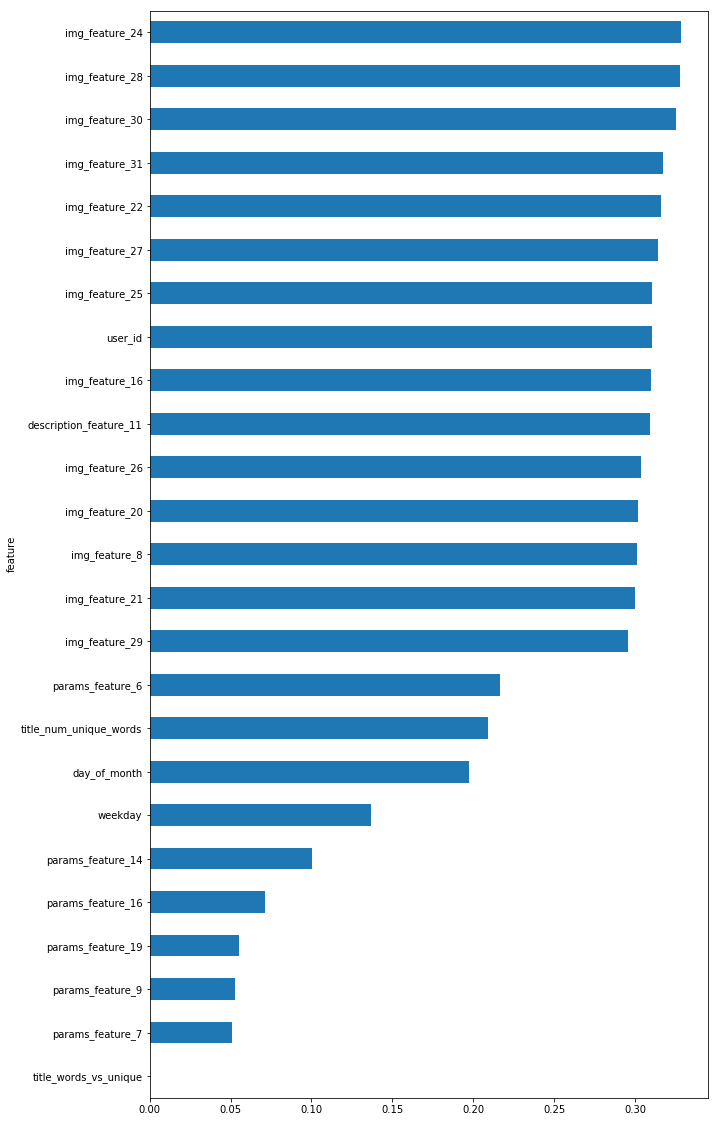

In [77]:
plt.show(); plt.clf()

In [78]:
#calculate_feature_importance(model, X_train.columns)

In [78]:
#y_pred = clf.predict(X_test)
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = np.clip(y_pred, 0, 1)

In [79]:
df_submission['deal_probability'] = y_pred

In [80]:
df_submission[['item_id','deal_probability']].to_csv('../../../submission.csv', index=False)

In [19]:
['4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c',
 '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58',
 '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83',
 'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae']



['4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c',
 '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58',
 '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83',
 'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae']

In [18]:
df_img = pd.DataFrame(df['image'], columns=['image'])

In [19]:
df_img.dropna(axis=0, inplace=True)

In [20]:
df_img.reset_index(inplace=True)

In [21]:
df_img.drop(labels=['index'], axis=1, inplace=True)

In [22]:
df_img = df_img[(df_img.image != '4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c')
              & (df_img.image != '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58')
              & (df_img.image != '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83')
              & (df_img.image != 'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae')]

In [23]:
len(df_img)

1390832

In [24]:
xception_model = xception.Xception(weights='imagenet')

In [25]:
img_path = '/media/axel/ssd/train/data/competition_files/'

In [26]:
#vgg_model = vgg.VGG16(weights='imagenet', include_top=False)

In [27]:
#vgg_model.layers.pop()

In [28]:
# x = vgg_model.layers[-1].output
# x = GlobalAveragePooling2D()(x)

In [29]:
#model = Model(input=vgg_model.input, outputs=x)

In [44]:
# img = Image.open(img_path + 'train_jpg/00000acce78ccf00d3ca0c550cae60fb319d45861444b310559a47dac016c383.jpg')
# target_size = (150, 150)
# if img.size != target_size:
#     img = img.resize(target_size)
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = xception.preprocess_input(x)


In [47]:
# model.predict(x)

array([[0.34469, 0.49798, 0.     , ..., 0.     , 0.03051, 0.     ]], dtype=float32)

In [32]:
#failed = []

In [33]:
# for i in tqdm(range(len(df_img))):
#     try:
#         img = Image.open(img_path + df_img['image'][i] + '.jpg')
#     except:
#         failed.append(str(df_img['image'][i]))

In [28]:
gen = ImageDataGenerator(preprocessing_function=xception.preprocess_input)

In [30]:
data_gen = gen.flow_from_directory(img_path, target_size=(150,150), batch_size=2000, shuffle=False)

Found 1390832 images belonging to 1 classes.


In [31]:
len(data_gen)

696

In [32]:
model = Model(inputs=xception_model.input, outputs=xception_model.get_layer('avg_pool').output)

In [33]:
preds = model.predict(data_gen.next()[0], verbose=0).astype(np.float16)

In [34]:
for i in tqdm(range(len(data_gen)-1)):
    preds = np.vstack((preds, model.predict(data_gen.next()[0], verbose=0).astype(np.float16)))

100%|██████████| 695/695 [2:05:18<00:00, 10.82s/it]  


In [36]:
preds[0]

array([0.3447 , 0.498  , 0.     , ..., 0.     , 0.03052, 0.     ], dtype=float16)

In [37]:
bcolz.carray(preds, rootdir=img_path, mode='w')

carray((1390832, 2048), float16)
  nbytes := 5.31 GB; cbytes := 5.11 GB; ratio: 1.04
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 512; chunksize: 2097152; blocksize: 32768
  rootdir := '/media/axel/ssd/train/data/competition_files/'
  mode    := 'w'
[[ 0.34472656  0.49804688  0.         ...,  0.          0.03051758  0.        ]
 [ 0.10443115  0.04989624  0.18334961 ...,  0.01448822  0.04537964  0.        ]
 [ 1.23046875  1.60546875  0.         ...,  0.01643372  0.          0.        ]
 ..., 
 [ 0.3605957   0.94042969  0.         ...,  0.12841797  0.03295898
   0.08215332]
 [ 0.          0.          0.64648438 ...,  0.          0.          0.86083984]
 [ 0.          0.23657227  0.         ...,  0.06414795  0.          0.        ]]

In [38]:
p = bcolz.open(img_path)

In [40]:
p[0]

array([0.3447 , 0.498  , 0.     , ..., 0.     , 0.03052, 0.     ], dtype=float16)

In [27]:
failed

['4f029e2a00e892aa2cac27d98b52ef8b13d91471f613c8d3c38e3f29d4da0b0c',
 '8513a91e55670c709069b5f85e12a59095b802877715903abef16b7a6f306e58',
 '60d310a42e87cdf799afcd89dc1b11ae3fdc3d0233747ec7ef78d82c87002e83',
 'b98b291bd04c3d92165ca515e00468fd9756af9a8f1df42505deed1dcfb5d7ae']